Let's import the needed libraries.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

Let's define our function

In [2]:
A = 8.8480182 
def f(x):
    if x < -3 or x > 3:
        return 0
    return (1/A) * (x**2) * (np.sin(np.pi*x)**2)

# What are we going to do?

To sample a large amount of points from the function, we will use the rejection sampling method. We will sample points from a uniform distribution and check if they are below the function value.

# Is value of A mandatory?

The value of A will be used to define the range of the uniform distribution so it is not mandatory to have.
But having it allows us to define better the maximum value form which draw points and reduce the amount of points
needed to be rejected.


# Part 1 - sampling points with rejection sampling

In [10]:
max_point = 0.8
samples = []
N = 150_000
fails = 0
BINS = 250

def g(x):
    return 1 #more or less 570k points rejected

c = max_point 

for i in range(N):
    U1, U2 = random.uniform(-3, 3), random.uniform(0, 1)

    while U2 > (f(U1) / (g(U1) * c)):
        fails+=1
        U1, U2 = random.uniform(-3, 3), random.uniform(0, 1)
    samples.append(U1)

print(f"To sample {N} points, we had to reject {fails} points.")

To sample 150000 points, we had to reject 569464 points.


# PART 2 - plotting the results

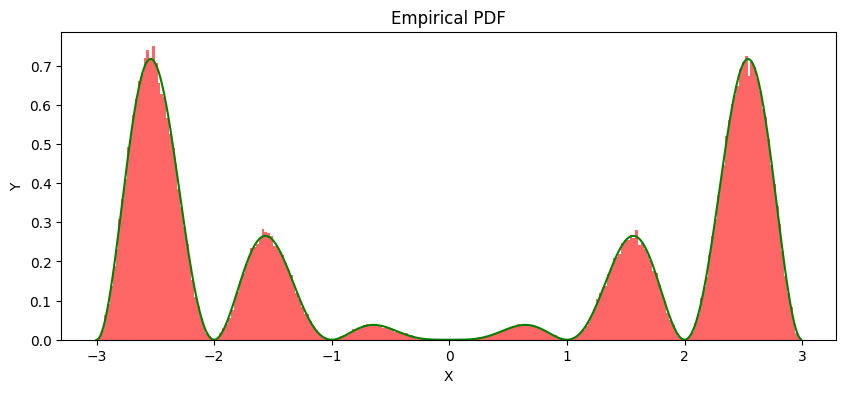

In [11]:
x_points = np.arange(-3, 3, 0.01)
y_points = list(map(f, x_points))

plt.figure(figsize=(10, 4))
plt.title('Empirical PDF')
plt.hist(samples, bins=BINS, density=True, alpha=0.6, color='red') #play with bins
plt.plot(x_points, y_points, color='green')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# PART 3 - confidence intervals computation

In [12]:
#Let's use this sampling function, exactly the same as before but rearranged differently
def sampling_procedure(N):
    
    for i in range(N):
        U1 = random.uniform(-3, 3)
        U2 = random.uniform(0, max_point)
    
        while U2 >= f(U1):
            U1 = random.uniform(-3, 3)
            U2 = random.uniform(0, max_point)
    
        samples.append(U1)
    
    return samples

In [13]:
#Samples some datapoints and consider top 200
N = 20_000
n = 200
samples = sampling_procedure(N)

## Computing CIs using regular procedure for large datasets

In [14]:
print("\t\t", "Regular procedure for large datasets\n")

confidence = 0.95

#CI for median
etha = 1.96
p = 0.5
j = np.floor(n*p-etha*np.sqrt(n*p*(1-p)))
k = np.ceil(n*p+etha*np.sqrt(n*p*(1-p))) + 1
sorted_n = samples[0:n]
sorted_n.sort()
print("Median: ")
print("\t", sorted_n[int(j)], sorted_n[int(k)])

#CI for 0.9 quantile
p = 0.9
j = np.floor(n*p-etha*np.sqrt(n*p*(1-p)))
k = np.ceil(n*p+etha*np.sqrt(n*p*(1-p))) + 1
sorted_n = samples[0:n]
sorted_n.sort()
print("0.9 quantile: ")
print("\t", sorted_n[int(j)], sorted_n[int(k)])

#CI for mean - using asymptotic case: we have no heavy tail
first_n = samples[0:n]
empirical_mean = sum(first_n) / n
empirical_std_dev = sum([(x - empirical_mean)**2 for x in first_n]) / n
print("Mean: ")
delta = etha * (np.sqrt(empirical_std_dev / n))
print("\t", empirical_mean - delta, empirical_mean + delta)

		 Regular procedure for large datasets

Median: 
	 -1.5229868342026398 1.4639145279511965
0.9 quantile: 
	 2.5884674996400348 2.7357594925095707
Mean: 
	 -0.398097117647036 0.23283043549925858


## Computing CIs using Bootstrap procedure

In [15]:
R, j, k = 999, 25, 975 #standard for confidence = 0.95

first_n = samples[0:n] 
bootstrap_sample = []
medians = []
means = []
percentiles_90 = []

for i in range(R):

    bootstrap_sample = []
    
    for j in range(n):
        bootstrap_sample.append(random.choice(first_n)) #implements sampling with replacement
    
    bootstrap_sample.sort()
    medians.append(0.5*(bootstrap_sample[int(np.floor(n/2))]+bootstrap_sample[int(np.floor(n/2))+1]))
    k1 = np.floor(n*0.9+0.1)
    k2 = np.ceil(n*0.95+0.1)
    percentiles_90.append(0.5*(bootstrap_sample[int(k1)]+bootstrap_sample[int(k2)]))
    means.append(sum(bootstrap_sample) / n)

medians.sort()
means.sort()
percentiles_90.sort()
print("Median: ")
print("\t", medians[j], medians[k])
print("0.9 quantile: ")
print("\t", percentiles_90[j], percentiles_90[k])
print("Mean: ")
print("\t", means[j], means[k])

Median: 
	 -1.3649533019722053 1.4639145279511965
0.9 quantile: 
	 2.678801578194473 2.7649912482947503
Mean: 
	 -0.215965011814315 0.24128055962607675


# PART 4 - Multiple CIs computation

In [17]:
sets = 100
partition = []

for j in range(sets):
    random.shuffle(samples) #superfluo - useless (since they are iid)
    partition.append(random.sample(samples, n))
    samples = samples[0:len(samples)-n]

#CI for mean - using asymptotic case: we have no heavy tail
confidence = 0.95
etha = 1.96

conf_inters = []

global_mean = sum(samples) / len(samples)

for i in range(sets):
    empirical_mean = sum(partition[i]) / n
    empirical_std_dev = sum([(x - empirical_mean)**2 for x in partition[i]]) / n
    delta = etha * (np.sqrt(empirical_std_dev / n))

    conf_inters.append((empirical_mean - delta, empirical_mean + delta))

print("We are done")

We are done


Let's plot the confidence intervals

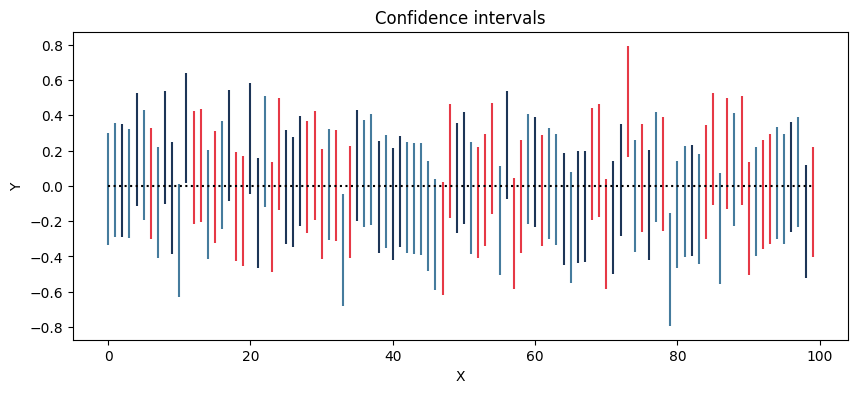

In [19]:
colors = ['#e63946', '#457b9d', '#1d3557']
plt.figure(figsize=(10, 4))
plt.title('Confidence intervals')
for i in range(sets):
    plt.vlines(i, conf_inters[i][0], conf_inters[i][1], color=colors[random.randint(0, 2)])
plt.plot(np.arange(sets), [global_mean for x in range(sets)], ls="dotted", color='black', label='Mean')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Here we show that a possible estimation of the mean falls in more or less the 95% of the CIs (so just 5 intervals - on average - will not contain the mean).

Then answer to the question is: 5% so 5 CIs will be wrong (since we have designed our experiment to be in a way that my CI will contain the mean 95% of the time).
